In [1]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api
import mlflow
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import joblib

In [2]:
import sys
sys.path.append("..")

from myscripts import modelprep


In [3]:
def load_data_dvc(path, git_revision):

    repo = 'https://github.com/fbagire/sales_predict'
    version = git_revision

    data_url = dvc.api.get_url(path=path, repo=repo, rev=version)

    mlflow.set_experiment('sales_predict')

    if __name__ == '__main__':
        warnings.filterwarnings('ignore')
        np.random.seed(40)
        with mlflow.start_run(nested=True) as mlrun:
            data = pd.read_csv(data_url, index_col=[0])

    return data

In [4]:
# git_rev
vf = '70a72e7e4cda6da4ab57bb8571e5cc2f3c5366e0'

train_df = load_data_dvc('data/train_model.csv', vf)

test_df = load_data_dvc('data/test_model.csv', vf)

train_df.shape, test_df.shape

# ### Data PreProcessing

# Remove Missing Values

((1017209, 19), (41088, 17))

In [41]:
importlib.reload(modelprep)

<module 'myscripts.modelprep' from '..\\myscripts\\modelprep.py'>

In [42]:
model_prep = modelprep.Modeller(train_df)

In [43]:
X_train, X_val, y_train, y_val = model_prep.split_data()

In [8]:
def fetch_logged_data(run_id):
    client = mlflow.tracking.MlflowClient()
    data = client.get_run(run_id).data
    tags = {k: v for k, v in data.tags.items() if not k.startswith("mlflow.")}
    artifacts = [f.path for f in client.list_artifacts(run_id, "model")]
    return data.params, data.metrics, tags, artifacts

In [9]:
estimators = 25
depth = 15
pipeline = Pipeline([('scaler', StandardScaler()),
                     ('rf_regressor',
                      RandomForestRegressor(n_estimators=estimators,
                                            max_depth=depth,
                                            min_samples_split=2,
                                            min_samples_leaf=1))])

In [10]:
val='validation_'

In [11]:
mlflow.set_experiment('sales_predict')
mlflow.sklearn.autolog()

with mlflow.start_run() as run:

    rf_model = pipeline.fit(X_train, y_train)
    y_pred = rf_model.predict(X_val)
    mse, rmse, r2 = model_prep.error_calculate(y_val, y_pred)
    mlflow.log_metrics({val + "mse": mse, val + 'rmse': rmse, val + 'r2': r2},step=1)
    mlflow.sklearn.log_model(rf_model, "Regressor model")

In [12]:
params, metrics, tags, artifacts = fetch_logged_data(run.info.run_id)

In [13]:
#Model serializing and saving
#creating a file name using the now timestamp
mdl_tmp = '../models/' + str(
    datetime.now().strftime("%d-%m-%Y-%H-%M-%S")) + '.pkl'
joblib.dump(rf_model, mdl_tmp)

['../models/05-08-2022-13-48-27.pkl']

**Feature Importance**

Displayin top 10

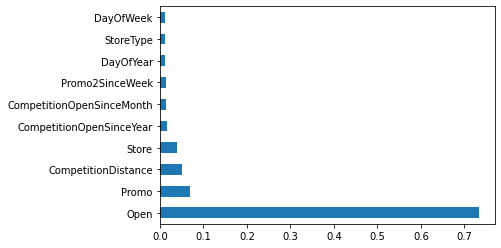

In [44]:
model_prep.feature_importance(pipeline.steps[1][1],x_train=X_train)

## Deep Learning